In [1]:
import os
import rasterio as rio
import numpy as np
import shapely
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl
from matplotlib.colors import TwoSlopeNorm, LogNorm
from matplotlib import cm
from matplotlib.colors import ListedColormap, LinearSegmentedColormap
import sklearn
from cmcrameri import cm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy.crs as ccrs
import cartopy as ctp

import sys
sys.path.append('../')
import snowFun

In [2]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

In [3]:
# define folder and file paths
folder_AGVA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"AGVA")
folder_dems = os.path.join(folder_AGVA, "DEMs", "time_varying_DEMs", "10m")
folder_class = os.path.join(folder_AGVA, 'classified images', 'S2_Classified_Cloudmasked_Merged')
folder_cloud = os.path.join(folder_AGVA, 'classified images', 'S2_Cloud_Merged')
folder_meta = os.path.join(folder_AGVA, "classified images", "meta csv", "S2")
folder_climate = os.path.join(folder_AGVA, "Climate")

# open rgi
path_rgi = os.path.join(folder_AGVA, 'RGI', "rgi_2km_o3regions", "rgi_2km_o3regions.shp")
rgi_gdf = gpd.read_file(path_rgi, include_fields=['RGIId', 'geometry'])

# open the big data csv
path_data = os.path.join(folder_AGVA, 'Derived products', 'S2', 'Final_Data_Table.csv')
data_df = pd.read_csv(path_data)

# subset rgi to the glaciers we have data for
rgi_gdf = rgi_gdf[ rgi_gdf['RGIId'].isin(data_df['RGIId']) ]
# print(rgi_gdf.columns)

# merge columns
all_data_gdf = gpd.GeoDataFrame(pd.merge(data_df, rgi_gdf, on="RGIId"))

# replace -9999 with nan
all_data_gdf[all_data_gdf==-9999] = np.nan

# what columns are available?
print(all_data_gdf.shape)
print(all_data_gdf.columns.values)

(3002, 65)
['RGIId' 'GLIMSId' 'BgnDate' 'EndDate' 'CenLon' 'CenLat' 'O1Region'
 'O2Region' 'Area' 'Zmin' 'Zmax' 'Zmed' 'Slope' 'Aspect' 'Lmax' 'Status'
 'Connect' 'Form' 'TermType' 'Surging' 'Linkages' 'Name' 'O3Region'
 'O3_name' 'ela_2018' 'ela_2019' 'ela_2020' 'ela_2021' 'ela_2022'
 'aar_2018' 'aar_2019' 'aar_2020' 'aar_2021' 'aar_2022' 'off_glacier_2018'
 'off_glacier_2019' 'off_glacier_2020' 'off_glacier_2021'
 'off_glacier_2022' 'date_2018' 'date_2019' 'date_2020' 'date_2021'
 'date_2022' 'ela_avg_product' 'aar_avg_product' 'aar_infill_avg_product'
 'off_glacier_avg_product' 'percent_observed_average_product' 'dhdt_1520'
 'dhdt_1020' 'distance_from_ocean' 'hyps_ela' 'hyps_aar' 'hyps_aar_20'
 'hyps_aar_40' 'hyps_aar_60' 'hyps_aar_80' 'hyps_aar_100' 'hyps_aar_120'
 'hyps_aar_140' 'hyps_aar_160' 'hyps_aar_180' 'hyps_aar_200' 'geometry']


In [4]:
# load CMIP climate products
mst = riox.open_rasterio(os.path.join(folder_climate, 'CMIP', "modern_summer_temp.tif"))
fst = riox.open_rasterio(os.path.join(folder_climate, 'CMIP', "future_summer_temp.tif"))
mwp = riox.open_rasterio(os.path.join(folder_climate, 'CMIP', "modern_winter_precip.tif"))
fwp = riox.open_rasterio(os.path.join(folder_climate, 'CMIP', "future_winter_precip.tif"))

# calcualte change in temp, precip
deltat = fst-mst
deltapm = fwp-mwp # magnitude
deltapp = (deltapm/mwp)*100 # percent

# calculate what that means for elas
delta_ela = -317.35*(deltapp/100) + 85.39*deltat

In [7]:
# print min, max of each
print("T:",np.nanmin(deltat),np.nanmax(deltat))
print("P:",np.nanmin(deltapp),np.nanmax(deltapp))
print("E:",np.nanmin(delta_ela),np.nanmax(delta_ela))

T: 1.6789856 3.203308
P: 3.885209 28.917233
E: 85.677216 249.2653


In [6]:
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [30]:
import importlib
importlib.reload(snowFun)

<module 'snowFun' from 'C:\\Users\\lzell\\OneDrive - Colostate\\Desktop\\AGVA\\scripts\\Figures\\..\\snowFun\\__init__.py'>

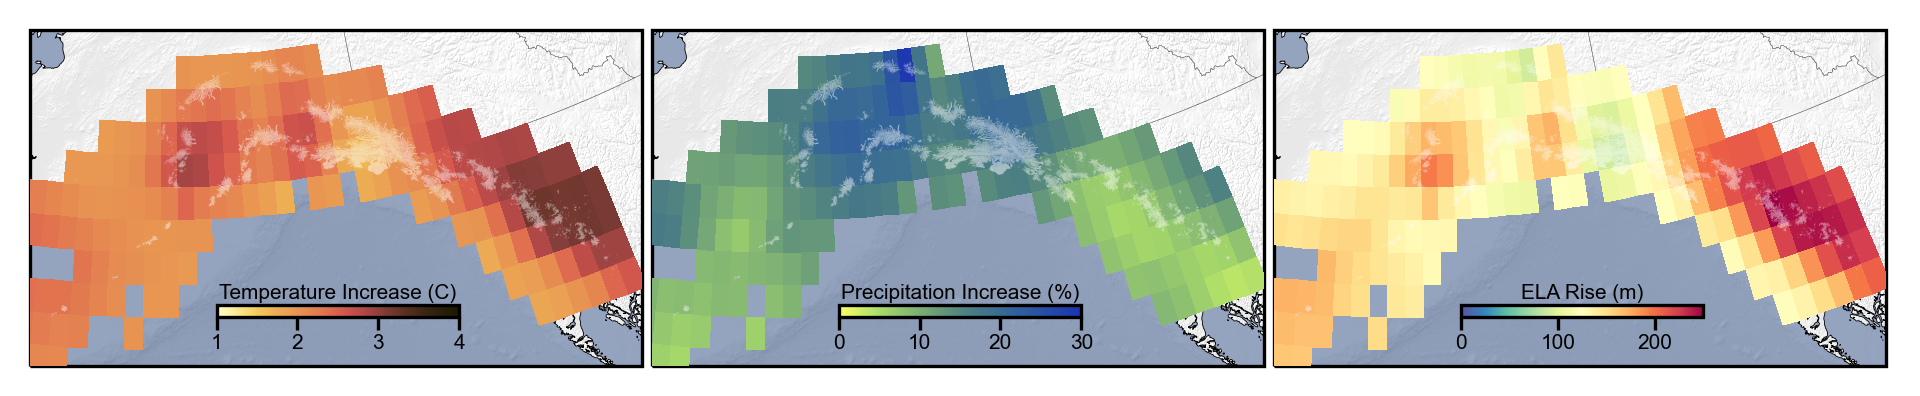

In [66]:
# define alaska albers projection
albers = ccrs.epsg(3338)

# initiate figure
fig,axs = snowFun.create_three_base_maps_row(hillshade=1, projection=albers)

cmap_pad = -0.1
cmap_fraction = 0.02

# add products on top
deltat.plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap=cm.lajolla_r, vmin=1, vmax=4, zorder=10,
              cbar_kwargs={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad, 'label':"Temperature Increase (C)"})

deltapp.plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap=cm.imola_r, vmin=0, vmax=30, zorder=10,
              cbar_kwargs={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad, 'label':"Precipitation Increase (%)"})

delta_ela.plot(ax=axs[2], transform=ccrs.PlateCarree(), cmap='Spectral_r', vmin=0, vmax=250, zorder=10,
              cbar_kwargs={"location":'bottom', "fraction":cmap_fraction, 'pad':cmap_pad, 'label':"ELA Rise (m)"})

for ax in axs:
    all_data_gdf.plot(ax=ax, zorder=10, color='white', alpha=0.5)

for ax in axs:
    ax.set_title("")
    
# format colorbars
for ax in fig.axes[-3:]:
    ax.tick_params(labelsize=5, length=3, pad=1)
    ax.set_xlabel(ax.get_xlabel(), size=5, labelpad=1.5) 
    ax.xaxis.set_label_position('top')

for ax in axs:
    ax.set_xlabel("")
    ax.set_ylabel("")

plt.tight_layout()
plt.subplots_adjust(hspace=0.01, wspace=0.01)

# save
out_path = os.path.join(folder_AGVA, 'Figures', 'future climate', 'future_climate.png')
plt.savefig(out_path, dpi=400, bbox_inches='tight', pad_inches=0.015)